In [1]:
import numpy as np
import matplotlib.pyplot as plt
from fourier import fourier_series_coeff

In [2]:
# Numerical parameters
eps = 1e-12
N = 100

## Global Parameters

In [3]:
# Non-dimensional parameters
# Cell length
L = 1.0

# Damkohler numbers
Dam_tr = 1.0
Dam_ci = 1.4

# Peclet numbers
Pen_tr = 10.0
Pen_ci = 15.0

Pen_tr_s = 10.0
Pen_ci_s = 15.0

# Biot numbers
Bit_tr = 1.0e3
Bit_ci = 3.33

# Marangoni numbers
Man = 1.03

# Switching rate
k_tr = 1.0
k_ci = 30 * k_tr

chi_tr = 30.0
chi_ci = 1.0

print(k_tr * chi_tr, k_ci * chi_ci)

assert k_tr * chi_tr == k_ci * chi_ci

30.0 30.0


In [4]:
# Light intensity
def f_1(x):
    """A 2L-periodic light intensity perturbation."""
    
    # return np.cos(np.pi * x / L)
    # return np.exp(-x**2 / 0.1)
    return np.exp(1 / (x**2 - 1 - eps)) - 0.22200
    

## Fourier Setup

In [5]:
# Set the frequencies
omega_full = np.arange(-N, N + 1) * np.pi / L
omega = np.concatenate([omega_full[:N], omega_full[N + 1:]])  # Excluding the zero frequency

In [6]:
# Extract Fourier coefficients
f_coeffs = fourier_series_coeff(lambda x: f_1(x - L), 2 * L, N - 1, return_complex=True)

f_o = f_coeffs[0]
f_h = lambda x: np.concatenate([f_coeffs[1:][::-1].conj(), f_coeffs[1:]])  # Exclude the zero mode

## Leading Order

### Setting Additional Parameters

In [7]:
# Setup required parameters
alpha = Dam_ci / Dam_tr
eta = Pen_tr / Pen_ci
zeta = Pen_tr * Dam_tr + Pen_ci * Dam_ci
beta = Bit_tr / Bit_ci
xi = Pen_ci * Bit_tr
nu = Dam_tr / Bit_tr

### Apply Boundary Conditions

In [8]:
# Define matrices
U = np.array([
    [alpha, eta],
    [1, -1]
])

In [9]:
# Quadratic coefficients
a = (
    ((eta - 1) / np.sqrt(zeta)) * np.sinh(np.sqrt(zeta)) * np.cosh(np.sqrt(zeta))
    * (eta * (nu * (1 + alpha) * beta + 1) * k_tr - (nu * (1 + alpha) + 1) * k_ci)
)

b = (
    (1 + alpha) * np.cosh(np.sqrt(zeta))
    * (eta * (nu * (1 + alpha) * beta + 1) * k_tr - (nu * (1 + alpha) + 1) * k_ci)
    + ((eta - 1) / np.sqrt(zeta)) * np.sinh(np.sqrt(zeta))
    * (alpha * (nu * (1 + alpha) * beta + 1) * k_tr + (nu * (1 + alpha) + 1) * k_ci)
)

c = (1 + alpha) * (alpha * (nu * (1 + alpha) * beta + 1) * k_tr + (nu * (1 + alpha) + 1) * k_ci)

d = (
    ((eta - 1) / np.sqrt(zeta)) * np.sinh(np.sqrt(zeta))
    + (1 / (chi_tr * k_tr) - 1 / (2 * L)) * np.cosh(np.sqrt(zeta))
    * (eta * (nu * (1 + alpha) * beta + 1) * k_tr - (nu * (1 + alpha) + 1) * k_ci)
)

e = (
    (1 + alpha)
    + (1 / (chi_tr * k_tr) - 1 / (2 * L))
    * (alpha * (nu * (1 + alpha) * beta + 1) * k_tr + (nu * (1 + alpha) + 1) * k_ci)
)

f = -1 / (2 * L)

p = (
    chi_ci * k_ci * np.sqrt(zeta) * np.sinh(np.sqrt(zeta)) * np.cosh(np.sqrt(zeta))
    * (
        ((1 + alpha) / xi) * (k_tr * beta * eta - k_ci)
        + ((alpha + eta) / zeta) * (k_tr * eta - k_ci)
    )
)

q = (
    chi_ci * k_ci * np.sqrt(zeta) * np.sinh(np.sqrt(zeta))
    * (
        alpha * k_tr * (((1 + alpha) * beta) / xi + (alpha + eta) / zeta)
        + k_ci * ((1 + alpha) / xi + (alpha + eta) / zeta)
    )
)

r = (
    chi_ci * k_ci * np.sqrt(zeta) * np.sinh(np.sqrt(zeta))
    * ((1 + alpha * beta) / xi + (alpha + eta) / zeta)
    + np.cosh(np.sqrt(zeta)) * (eta * k_tr + alpha * k_ci)
)

s = alpha * (k_tr - k_ci)

In [10]:
# Solve for B_1
poly = np.poly1d([
    a * q**2 - b * p * q + c * p**2,
    2 * a * q * s - b * p * s - b * q * r + 2 * c * p * r + d * q**2 - e * p * q,
    a * s**2 - b * r * s + c * r**2 + 2 * d * q * s - e * p * s - e * q * r + f * q**2,
    d * s**2 - e * r * s + 2 * f * q * s,
    f * s**2
])
roots = poly.r
print(roots)

[ 1.22733777e+12  2.48794921e-03 -9.26361291e-04  5.82728234e-04]


In [11]:
# Select a root
B_1 = roots[3]

In [12]:
# Solve for B_0
B_0 = -(p * B_1**2 + r * B_1) / (q * B_1 + s)

### Solutions to Leading Order

In [13]:
# Bulk concentrations
def w(y):
    return np.array([B_0, B_1 * np.cosh(y * np.sqrt(zeta))])

def d_w(y):
    return np.array([0, B_1 * np.sqrt(zeta) * np.sinh(y * np.sqrt(zeta))])

def d2_w(y):
    return np.array([0, B_1 * zeta * np.cosh(y * np.sqrt(zeta))])

def c_0(y):
    return U @ w(y)

def c_tr_0(y):
    return alpha * B_0 + eta * B_1 * np.cosh(y * np.sqrt(zeta))

def c_ci_0(y):
    return B_0 - B_1 * np.cosh(y * np.sqrt(zeta))

# Surface concentrations
Delta = nu * (1 + alpha) * (beta * k_tr * c_tr_0(1) + k_ci * c_ci_0(1)) + k_tr * c_tr_0(1) + k_ci * c_ci_0(1) + 1

gamma_0 = (
    (1 / Delta) * (nu * (beta * k_tr * c_tr_0(1) + k_ci * c_ci_0(1)) * np.array([alpha, 1])
    + np.array([k_tr * c_tr_0(1), k_ci * c_ci_0(1)]))
)

gamma_tr_0 = (nu * (beta * k_tr * c_tr_0(1) + k_ci * c_ci_0(1)) * alpha + k_tr * c_tr_0(1)) / Delta

gamma_ci_0 = (nu * (beta * k_tr * c_tr_0(1) + k_ci * c_ci_0(1)) + k_ci * c_ci_0(1)) / Delta

assert abs(gamma_tr_0 - gamma_0[0]) < eps
assert abs(gamma_ci_0 - gamma_0[1]) < eps

assert abs((gamma_tr_0 + gamma_ci_0) - (1 - 1 / Delta)) < eps

### Solution Plots to Leading Order

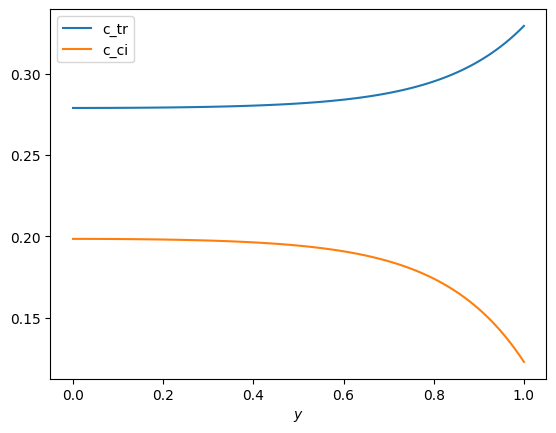

In [14]:
yy = np.linspace(0, 1, 100)

plt.plot(yy, c_tr_0(yy), label="c_tr")
plt.plot(yy, c_ci_0(yy), label="c_ci")
plt.xlabel(r"$y$")
plt.legend()
plt.show()

## First Order

### Setup Constants

In [15]:
# Define matrices
A_s = np.array([
    [Pen_tr_s * Dam_tr, -Pen_tr_s * Dam_ci],
    [-Pen_ci_s * Dam_tr, Pen_ci_s * Dam_ci]
])

P = np.array([
    [Pen_tr, 0],
    [0, Pen_ci]
])

P_s = np.array([
    [Pen_tr_s, 0],
    [0, Pen_ci_s]
])

B = np.array([
    [Bit_tr, 0],
    [0, Bit_ci]
])

K = np.array([
    [k_tr, 0],
    [0, k_ci]
])

M = A_s + P_s @ B @ np.array([
    [k_tr * c_tr_0(1) + 1, k_tr * c_tr_0(1)],
    [k_ci * c_ci_0(1), k_ci * c_ci_0(1) + 1]
])

z = np.ones(2).reshape(1, 2)

I = np.eye(2)

### Expand Solutions in Terms of Unknown Parameters $\omega \neq 0$

In [16]:
unknowns = ["A_h", "B_h", "C_h", "D_h", "E_h", "F_h", "G_h", "H_h", "gamma_tr_h", "gamma_ci_h", "S_h", "const"]

def to_arr(vals, omega):
    """Converts a dictionary of values to an array."""
    arr = np.zeros((len(unknowns), len(omega)), dtype=complex)
    for key in vals.keys():
        if key not in unknowns:
            raise ValueError(f"Unknown key: {key}")

    for i, key in enumerate(unknowns):
        try:
            arr[i, :] = vals[key]
        except KeyError:
            pass
    
    return arr


In [17]:
# Streamfunction
def psi_h(omega, y):
    return to_arr({
        "A_h": y * np.exp(omega * y),
        "B_h": np.exp(omega * y),
        "C_h": y * np.exp(-omega * y),
        "D_h": np.exp(-omega * y),
    }, omega)

def d_psi_h(omega, y):
    return to_arr({
        "A_h": (1 + omega * y) * np.exp(omega * y),
        "B_h": omega * np.exp(omega * y),
        "C_h": (1 - omega * y) * np.exp(-omega * y),
        "D_h": -omega * np.exp(-omega * y),
    }, omega)

def d2_psi_h(omega, y):
    return to_arr({
        "A_h": omega * (2 + omega * y) * np.exp(omega * y),
        "B_h": omega**2 * np.exp(omega * y),
        "C_h": -omega * (2 - omega * y) * np.exp(-omega * y),
        "D_h": omega**2 * np.exp(-omega * y),
    }, omega)

def d3_psi_h(omega, y):
    return to_arr({
        "A_h": omega**2 * (3 + omega * y) * np.exp(omega * y),
        "B_h": omega**3 * np.exp(omega * y),
        "C_h": omega**2 * (3 - omega * y) * np.exp(-omega * y),
        "D_h": -omega**3 * np.exp(-omega * y),
    }, omega)

In [18]:
# Define coefficients for bulk concentration
def a_p(omega):
    return (1 / (2 * omega * np.sqrt(zeta) + zeta)) * to_arr({
        "A_h": 1,
    }, omega)

def b_p(omega):
    return (1 / (2 * omega * np.sqrt(zeta) + zeta)**2) * to_arr({
        "A_h": -2 * (omega + np.sqrt(zeta)),
        "B_h": 2 * omega * np.sqrt(zeta) + zeta,
    }, omega)

def c_p(omega):
    return (1 / (2 * omega * np.sqrt(zeta) - zeta)) * to_arr({
        "A_h": 1,
    }, omega)

def d_p(omega):
    return (1 / (2 * omega * np.sqrt(zeta) - zeta)**2) * to_arr({
        "A_h": 2 * (omega - np.sqrt(zeta)),
        "B_h": 2 * omega * np.sqrt(zeta) - zeta,
    }, omega)

def e_p(omega):
    return (1 / (2 * omega * np.sqrt(zeta) - zeta)) * to_arr({
        "A_h": 1,
        "B_h": 2 * omega,
    }, omega)

def f_p(omega):
    return (1 / (2 * omega * np.sqrt(zeta) - zeta)**2) * to_arr({
        "A_h": -2 * (omega - np.sqrt(zeta)),
        "B_h": (
            2 * omega * np.sqrt(zeta) - zeta
            - 4 * omega * (omega - np.sqrt(zeta))
        ),
    }, omega)

def g_p(omega):
    return (1 / (2 * omega * np.sqrt(zeta) + zeta)) * to_arr({
        "A_h": 1,
        "B_h": 2 * omega,
    }, omega)

def h_p(omega):
    return (1 / (2 * omega * np.sqrt(zeta) + zeta)**2) * to_arr({
        "A_h": 2 * (omega + np.sqrt(zeta)),
        "B_h": (
            2 * omega * np.sqrt(zeta) + zeta
            + 4 * omega * (omega + np.sqrt(zeta))
        ),
    }, omega)

In [19]:
# Bulk concentration
def p_h_0(omega, y):
    eq_1 = to_arr({
        "E_h": np.sinh(omega * y),
        "F_h": np.cosh(omega * y),
    }, omega)
    eq_2 = to_arr({
        "G_h": np.sinh(np.sqrt(zeta + omega**2) * y),
        "H_h": np.cosh(np.sqrt(zeta + omega**2) * y),
    }, omega)

    return np.array([eq_1, eq_2])

def p_h_1(omega, y):
    eq_1 = to_arr({
        "const": -B_0,
    }, omega)
    eq_2 = -B_1 * (1 + zeta / omega**2) * to_arr({
        "const": np.cosh(np.sqrt(zeta) * y),
    }, omega)

    return f_h(omega) * np.array([eq_1, eq_2])

def p_h_2_s(omega, y):
    return (
        (a_p(omega) * y + b_p(omega)) * np.exp((omega + np.sqrt(zeta)) * y)
        + (c_p(omega) * y + d_p(omega)) * np.exp((omega - np.sqrt(zeta)) * y)
        + (e_p(omega) * y + f_p(omega)) * np.exp((-omega + np.sqrt(zeta)) * y)
        + (g_p(omega) * y + h_p(omega)) * np.exp((-omega - np.sqrt(zeta)) * y)
    )

def p_h_2(omega, y):
    return (
        -((1.j * omega * np.sqrt(zeta) * B_1 * Pen_ci) / (2 * (alpha + eta)))
        * p_h_2_s(omega, y)
        * np.array([eta * (eta - 1), alpha + eta**2])[:, np.newaxis, np.newaxis]
    )

def p_h(omega, y):
    return p_h_0(omega, y) + p_h_1(omega, y) + p_h_2(omega, y)

In [20]:
# Bulk concentration derivative
def d_p_h_0(omega, y):
    eq_1 = omega * to_arr({
        "E_h": np.cosh(omega * y),
        "F_h": np.sinh(omega * y),
    }, omega)
    eq_2 = np.sqrt(zeta + omega**2) * to_arr({
        "G_h": np.cosh(np.sqrt(zeta + omega**2) * y),
        "H_h": np.sinh(np.sqrt(zeta + omega**2) * y),
    }, omega)

    return np.array([eq_1, eq_2])

def d_p_h_1(omega, y):
    eq_1 = to_arr({}, omega)
    eq_2 = -B_1 * (1 + zeta / omega**2) * to_arr({
        "const": np.sqrt(zeta) * np.sinh(np.sqrt(zeta) * y),
    }, omega)

    return f_h(omega) * np.array([eq_1, eq_2])

def d_p_h_2_s(omega, y):
    return (
        b_p(omega) * np.exp((omega + np.sqrt(zeta)) * y)
        + d_p(omega) * np.exp((omega - np.sqrt(zeta)) * y)
        + f_p(omega) * np.exp((-omega + np.sqrt(zeta)) * y)
        + h_p(omega) * np.exp((-omega - np.sqrt(zeta)) * y)
        + (omega + np.sqrt(zeta)) * (a_p(omega) * y + b_p(omega)) * np.exp((omega + np.sqrt(zeta)) * y)
        + (omega - np.sqrt(zeta)) * (c_p(omega) * y + d_p(omega)) * np.exp((omega - np.sqrt(zeta)) * y)
        + (-omega + np.sqrt(zeta)) * (e_p(omega) * y + f_p(omega)) * np.exp((-omega + np.sqrt(zeta)) * y)
        + (-omega - np.sqrt(zeta)) * (g_p(omega) * y + h_p(omega)) * np.exp((-omega - np.sqrt(zeta)) * y)
    )

def d_p_h_2(omega, y):
    return (
        -((1.j * omega * np.sqrt(zeta) * B_1 * Pen_ci) / (2 * (alpha + eta)))
        * d_p_h_2_s(omega, y)
        * np.array([eta * (eta - 1), alpha + eta**2])[:, np.newaxis, np.newaxis]
    )

def d_p_h(omega, y):
    return d_p_h_0(omega, y) + d_p_h_1(omega, y) + d_p_h_2(omega, y)

### Apply Boundary Conditions

In [21]:
# No-slip, no-penetration conditions
def no_slip(omega):
    return np.array([d_psi_h(omega, 0), omega * psi_h(omega, 0)])

In [22]:
# Kinematic condition
def kinematic(omega):
    return np.array([psi_h(omega, 1)])

In [23]:
# Normal stress balance
def normal_stress(omega):
    lhs = d3_psi_h(omega, 1) - 3 * omega**2 * d_psi_h(omega, 1)
    rhs = 1.j * omega**3 * (1 - Man * np.log(Delta)) * to_arr({
        "S_h": 1,
    }, omega)

    return np.array([lhs - rhs])

In [24]:
# No-flux condition
def no_flux(omega):
    return d_p_h(omega, 0)

In [25]:
# Surface excess concentration equations
def J_h(omega):
    S_vec = np.tile(to_arr({"S_h": 1}, omega), (2, 1, 1))
    eq_2 = p_h(omega, 1) + S_vec * d_w(1)[:, np.newaxis, np.newaxis]
    eq_3 = (1 / Delta) * np.tensordot(K @ U, eq_2, axes=1)

    gamma_tr_vec = to_arr({
        "gamma_tr_h": 1,
    }, omega)
    gamma_ci_vec = to_arr({
        "gamma_ci_h": 1,
    }, omega)
    eq_5 = -(K @ U @ w(1))[:, np.newaxis, np.newaxis] * np.tile((gamma_tr_vec + gamma_ci_vec), (2, 1, 1))

    eq_6 = -np.array([gamma_tr_vec, gamma_ci_vec])

    return np.tensordot(B, eq_3 + eq_5 + eq_6, axes=1)

def surf_excess(omega):
    eq_1 = 1.j * omega * (np.tile(d_psi_h(omega, 1), (2, 1, 1)) * (P_s @ gamma_0)[:, np.newaxis, np.newaxis])

    gamma_tr_vec = to_arr({"gamma_tr_h": 1}, omega)
    gamma_ci_vec = to_arr({"gamma_ci_h": 1}, omega)
    gamma_vec = np.array([gamma_tr_vec, gamma_ci_vec])
    eq_2 = omega**2 * gamma_vec

    eq_3 = -np.tensordot(P_s, J_h(omega), axes=1)

    f_vec = to_arr({"const": f_h(omega)}, omega)
    eq_4 = gamma_vec + np.tile(f_vec, (2, 1, 1)) * gamma_0[:, np.newaxis, np.newaxis]
    eq_5 = np.tensordot(A_s, eq_4, axes=1)

    return eq_1 + eq_2 + eq_3 + eq_5

In [26]:
# Tangential stress balance
def tangential_stress(omega):
    lhs = d2_psi_h(omega, 1) + omega**2 * psi_h(omega, 1)
    rhs = -1.j * omega * Man * Delta * to_arr({
        "gamma_tr_h": 1,
        "gamma_ci_h": 1,
    }, omega)

    return np.array([lhs - rhs])

In [27]:
# Mass balance
def mass_balance(omega):
    S_vec = np.tile(to_arr({"S_h": 1}, omega), (2, 1, 1))
    eq_1 = d_p_h(omega, 1) + S_vec * d2_w(1)[:, np.newaxis, np.newaxis]
    lhs = k_tr * chi_tr * np.tensordot(U, eq_1, axes=1)

    rhs = -np.tensordot(P, J_h(omega), axes=1)

    return lhs - rhs

In [28]:
# Collate equations
def form_equations(omega):
    return np.concatenate([
        no_slip(omega),
        kinematic(omega),
        normal_stress(omega),
        no_flux(omega),
        surf_excess(omega),
        tangential_stress(omega),
        mass_balance(omega),
    ], axis=0)

### Solutions for Constants of Integration

In [29]:
# Form linear system for the unknowns
sys = form_equations(omega)
forcing = sys[:, -1, :]

In [30]:
# Compute unknowns
sols = np.array([np.linalg.solve(sys[:, :-1, i], -forcing[:, i]) for i in range(2 * N)])

### Test Against Analytical Solutions

In [31]:
assert np.allclose(sols[:, 1], -(sols[:, 0] * np.sinh(omega)) / (np.sinh(omega) - omega * np.exp(-omega)))  # Check for B_h

### Expand Solutions in Terms of Unknown Parameters $\omega = 0$

In [32]:
# Setup array of single omega
omega_o = np.zeros(1)

In [33]:
# Streamfunction
def psi_o(y):
    return to_arr({
        "A_h": y**3,
        "B_h": y**2,
        "C_h": y,
        "D_h": 1,
    }, omega_o)

def d_psi_o(y):
    return to_arr({
        "A_h": 3 * y**2,
        "B_h": 2 * y,
        "C_h": 1,
    }, omega_o)

def d2_psi_o(y):
    return to_arr({
        "A_h": 6 * y,
        "B_h": 2,
    }, omega_o)

def d3_psi_o(y):
    return to_arr({
        "A_h": 6,
    }, omega_o)

In [34]:
# Bulk concentration
def p_o_0(y):
    eq_1 = to_arr({
        "E_h": y,
        "F_h": 1,
    }, omega_o)
    eq_2 = to_arr({
        "G_h": np.sinh(np.sqrt(zeta) * y),
        "H_h": np.cosh(np.sqrt(zeta) * y),
    }, omega_o)

    return np.array([eq_1, eq_2])

def p_o_1(y):
    eq_1 = ((B_1 * np.sqrt(zeta) * f_o) / 2) * to_arr({
        "const": y * np.sinh(np.sqrt(zeta) * y),
    }, omega_o)

    return np.array([to_arr({}, omega_o), eq_1])

def p_o(y):
    return p_o_0(y) + p_o_1(y)

In [35]:
def d_p_o_0(y):
    eq_1 = to_arr({
        "E_h": 1,
        "F_h": 0,
    }, omega_o)
    eq_2 = np.sqrt(zeta) * to_arr({
        "G_h": np.cosh(np.sqrt(zeta) * y),
        "H_h": np.sinh(np.sqrt(zeta) * y),
    }, omega_o)

    return np.array([eq_1, eq_2])

def d_p_o_1(y):
    eq_1 = ((B_1 * zeta * f_o) / 2) * to_arr({
        "const": (
            np.sinh(np.sqrt(zeta) * y)
            + y * np.sqrt(zeta) * np.cosh(np.sqrt(zeta) * y)
        ),
    }, omega_o)

    return np.array([to_arr({}, omega_o), eq_1])

def d_p_o(y):
    return d_p_o_0(y) + d_p_o_1(y)

In [36]:
eq_1 = to_arr({
    "E_h": 0.5,
    "F_h": 1,
}, omega_o)

eq_2 = (1 / np.sqrt(zeta)) * to_arr({
    "G_h": np.cosh(np.sqrt(zeta)) - 1,
    "H_h": np.sinh(np.sqrt(zeta)),
}, omega_o)

i_p_o_0 = np.array([eq_1, eq_2])

eq_1 = ((B_1 * zeta * f_o) / 2) * to_arr({
    "const": (
        np.cosh(np.sqrt(zeta)) / np.sqrt(zeta)
        - np.sinh(np.sqrt(zeta)) / zeta
    ),
}, omega_o)

i_p_o_1 = np.array([to_arr({}, omega_o), eq_1])

i_p_o = i_p_o_0 + i_p_o_1

### Apply Boundary Conditions

In [37]:
# No-slip, no-penetration conditions
no_slip_o = np.array([d_psi_o(0), psi_o(0)])

In [38]:
# Normal stress balance
normal_stress_o = np.array([d3_psi_o(1)])

In [39]:
# No-flux condition
no_flux_o = d_p_o(0)

In [40]:
# Kinetic flux
S_vec = np.tile(to_arr({"S_h": 1}, omega_o), (2, 1, 1))
eq_2 = p_o(1) + S_vec * d_w(1)[:, np.newaxis, np.newaxis]
eq_3 = (1 / Delta) * np.tensordot(K @ U, eq_2, axes=1)

gamma_tr_vec = to_arr({
    "gamma_tr_h": 1,
}, omega_o)
gamma_ci_vec = to_arr({
    "gamma_ci_h": 1,
}, omega_o)
eq_5 = -(K @ U @ w(1))[:, np.newaxis, np.newaxis] * np.tile((gamma_tr_vec + gamma_ci_vec), (2, 1, 1))

eq_6 = -np.array([gamma_tr_vec, gamma_ci_vec])

J_o = np.tensordot(B, eq_3 + eq_5 + eq_6, axes=1)

In [41]:
# Surface excess concentration equations
gamma_tr_vec = to_arr({"gamma_tr_h": 1}, omega_o)
gamma_ci_vec = to_arr({"gamma_ci_h": 1}, omega_o)
gamma_vec = np.array([gamma_tr_vec, gamma_ci_vec])

eq_1 = np.tensordot(P_s, J_o, axes=1)

f_vec = to_arr({"const": f_o}, omega_o)
eq_2 = gamma_vec + np.tile(f_vec, (2, 1, 1)) * gamma_0[:, np.newaxis, np.newaxis]
eq_3 = np.tensordot(A_s, eq_2, axes=1)

surf_excess_o = eq_1 - eq_3

In [42]:
# Tangential stress balance
tangential_stress_o = np.array([d2_psi_o(1)])

In [43]:
# Mass balance
S_vec = np.tile(to_arr({"S_h": 1}, omega_o), (2, 1, 1))
eq_1 = d_p_o(1) + S_vec * d2_w(1)[:, np.newaxis, np.newaxis]
lhs = k_tr * chi_tr * np.tensordot(U, eq_1, axes=1)

rhs = -np.tensordot(P, J_o, axes=1)

mass_balance_o = lhs - rhs

In [44]:
# Integral conditions
gamma_vec = to_arr({
    "gamma_tr_h": 1,
    "gamma_ci_h": 1,
}, omega_o)

eq_1 = to_arr({
    "S_h": c_tr_0(1) + c_ci_0(1),
}, omega_o)
eq_2 = np.tensordot(U, i_p_o, axes=1)
eq_3 = np.sum(eq_2, axis=0)

integral_o = np.array([eq_1 + gamma_vec / (k_tr * chi_tr) + eq_3])

In [45]:
# Conservation of mass
conserve_mass_o = np.array([to_arr({"S_h": 1}, omega_o)])

In [46]:
# Collate equations
sys_o = np.concatenate([
    no_slip_o,
    normal_stress_o,
    no_flux_o,
    surf_excess_o,
    tangential_stress_o,
    mass_balance_o,
    integral_o,
    # conserve_mass_o,
], axis=0)[:, :, 0]
forcing_o = sys_o[:, -1]

In [47]:
# Compute unknowns
sols_o = np.linalg.solve(sys_o[:, :-1], -forcing_o)

### Test against analytic solutions

In [48]:
assert sols_o[1] == -1.5 * sols_o[0]  # B_h = -3/2 A_h
assert abs(sols_o[4]) < eps  # E_h = 0
assert abs(sols_o[6]) < eps  # G_h = 0

### Solutions to First Order

In [49]:
def psi_f(y):
    val_o = psi_o(y)
    val_h = psi_h(omega, y)
    return np.concatenate([
        [val_o[:-1, 0] @ sols_o + val_o[-1, 0]],
        np.einsum("ij,ji->i", sols, val_h[:-1]) + val_h[-1],
    ])

def u_f(y):
    val_o = d_psi_o(y)
    val_h = d_psi_h(omega, y)
    return np.concatenate([
        [val_o[:-1, 0] @ sols_o + val_o[-1, 0]],
        np.einsum("ij,ji->i", sols, val_h[:-1] + val_h[-1]),
    ])

def v_f(y):
    val_h = psi_h(omega, y)
    return np.concatenate([
        [0],
        -1.j * omega * (np.einsum("ij,ji->i", sols, val_h[:-1]) + val_h[-1]),
    ])

def p_f(y):
    val_o = p_o(y)
    val_h = p_h(omega, y)
    return np.concatenate([
        (val_o[:, :-1, 0] @ sols_o)[:, np.newaxis] + val_o[:, -1],
        np.einsum("ijk,kji->ki", np.tile(sols[:, :-1, np.newaxis], (1, 1, 2)), val_h[:, -1:, :]) + val_h[:, -1],
    ], axis=1)

def c_f(y):
    return np.tensordot(U, p_f(y), axes=1)

def c_tr_f(y):
    return c_f(y)[0]

def c_ci_f(y):
    return c_f(y)[1]

def gamma_tr_f():
    return np.concatenate([
        [sols_o[-3]],
        sols[:, -3],
    ])

def gamma_ci_f():
    return np.concatenate([
        [sols_o[-2]],
        sols[:, -2],
    ])

def S_f():
    return np.concatenate([
        [sols_o[-1]],
        sols[:, -1],
    ])

In [50]:
def invert(f):
    def _(x, *args):
        coeffs = f(*args)
        return coeffs[0] + np.sum(coeffs[1:, np.newaxis] * np.exp(1.j * omega[:, np.newaxis] * (x + L)[np.newaxis, :]), axis=0)

    return _

In [51]:
psi = invert(psi_f)
u = invert(u_f)
v = invert(v_f)
c_tr = invert(c_tr_f)
c_ci = invert(c_ci_f)
gamma_tr = invert(gamma_tr_f)
gamma_ci = invert(gamma_ci_f)
S = invert(S_f)

In [52]:
xx = np.linspace(-L, L, 100)
yy = np.linspace(0, 1, 100)

In [53]:
uu = np.array([u(xx, y) for y in yy])
vv = np.array([v(xx, y) for y in yy])
cc_tr = np.array([c_tr(xx, y) for y in yy])
cc_ci = np.array([c_ci(xx, y) for y in yy])

ggamma_tr = gamma_tr(xx)
ggamma_ci = gamma_ci(xx)
SS = S(xx)

### Solution plots

#### Interfacial values

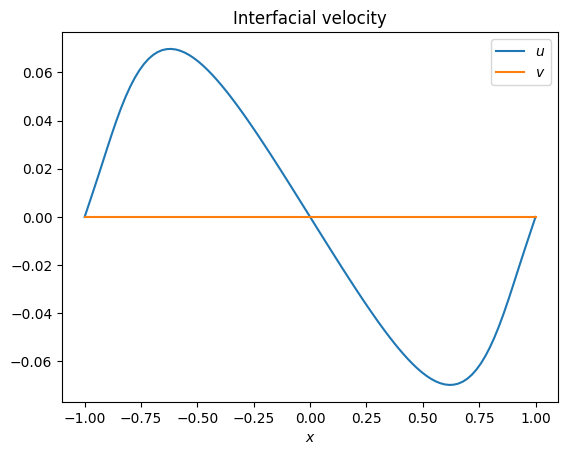

In [54]:
plt.plot(xx, uu[-1, :].real, label=r"$u$")
plt.plot(xx, vv[-1, :].real, label=r"$v$")
plt.title("Interfacial velocity")
plt.xlabel(r"$x$")
plt.legend()
plt.show()

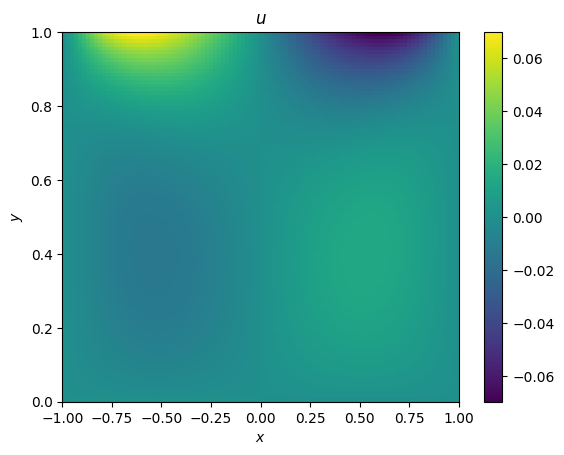

In [55]:
plt.imshow(uu[::-1, :].real, extent=[-L, L, 0, 1], aspect="auto")
plt.colorbar()
plt.title(r"$u$")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()

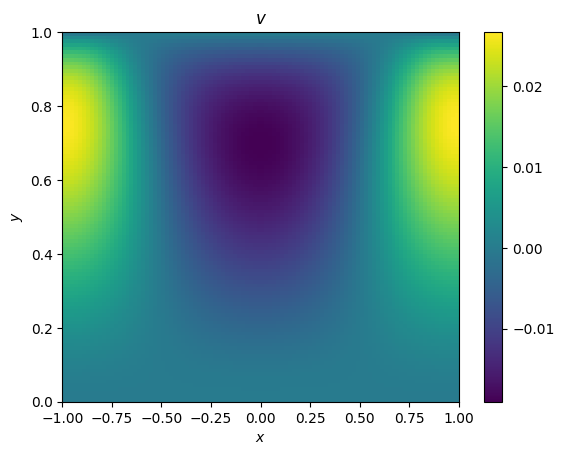

In [56]:
plt.imshow(vv[::-1, :].real, extent=[-L, L, 0, 1], aspect="auto")
plt.colorbar()
plt.title(r"$v$")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()

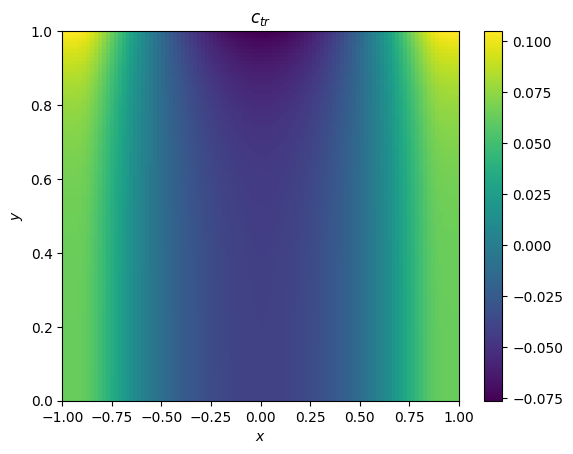

In [57]:
plt.imshow(cc_tr[::-1, :].real, extent=[-L, L, 0, 1], aspect="auto")
plt.colorbar()
plt.title(r"$c_{tr}$")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()

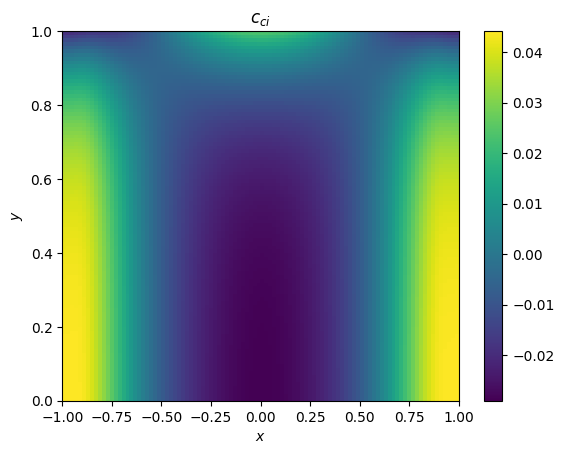

In [58]:
plt.imshow(cc_ci[::-1, :].real, extent=[-L, L, 0, 1], aspect="auto")
plt.colorbar()
plt.title(r"$c_{ci}$")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()

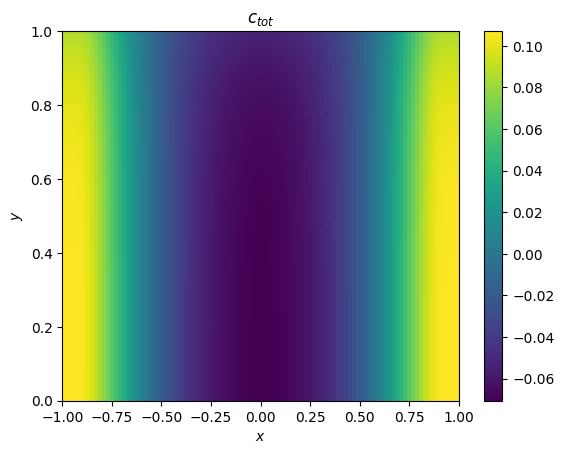

In [59]:
plt.imshow(cc_ci[::-1, :].real + cc_tr[::-1, :].real, extent=[-L, L, 0, 1], aspect="auto")
plt.colorbar()
plt.title(r"$c_{tot}$")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()

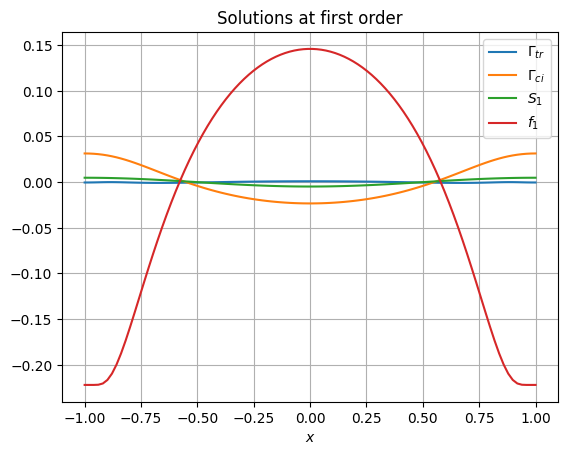

In [60]:
plt.plot(xx, ggamma_tr.real, label=r"$\Gamma_{tr}$")
plt.plot(xx, ggamma_ci.real, label=r"$\Gamma_{ci}$")
plt.plot(xx, SS.real, label=r"$S_1$")
plt.plot(xx, f_1(xx), label=r"$f_1$")
plt.xlabel(r"$x$")
plt.title("Solutions at first order")
plt.legend()
plt.grid()
plt.show()


### Testing